In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import os

In [2]:
train_folder = 'data/train'
test_folder = 'data/test'

def convert_sample(path):
    return np.load(os.path.join(path,'fnc.npy')), np.load(os.path.join(path,'icn_tc.npy'))


def get_train_set():
    fnc_list = []
    icn_tc_list = []
    targets = []
    for folder in os.listdir(train_folder):
        for sample in os.listdir(os.path.join(train_folder,folder)):
            fnc, icn_tc = convert_sample(os.path.join(train_folder,folder,sample))
            fnc_list.append(torch.tensor(fnc.reshape(5460), dtype=torch.float32))
            icn_tc_list.append(torch.tensor(icn_tc, dtype=torch.float32))
            targets.append(torch.tensor([1 if folder=="BP" else 0 ], dtype=torch.float32))

    return fnc_list, icn_tc_list, targets

def get_data_set():
    data_set = []
    for folder in os.listdir(train_folder):
        for sample in os.listdir(os.path.join(train_folder,folder)):
            fnc, icn_tc = convert_sample(os.path.join(train_folder,folder,sample))
            target = torch.tensor([1 if folder=="BP" else 0 ], dtype=torch.float32)
            data_set.append((torch.tensor(fnc.reshape(5460), dtype=torch.float32), target))

    return data_set

def get_icn_data():
    data_set = []
    for folder in os.listdir(train_folder):
        for sample in os.listdir(os.path.join(train_folder,folder)):
            fnc, icn_tc = convert_sample(os.path.join(train_folder,folder,sample))
            target = torch.tensor([1 if folder=="BP" else 0 ], dtype=torch.float32)
            data_set.append(torch.tensor(icn_tc, dtype=torch.float32))

    return data_set

def get_test_set():
    fnc_list = []
    icn_tc_list = []
    names = []
    for folder in os.listdir(test_folder):
        fnc, icn_tc = convert_sample(os.path.join(test_folder,folder))
        fnc_list.append(fnc.reshape(5460))
        icn_tc_list.append(icn_tc)
        names.append(folder)
        
    return fnc_list, icn_tc_list, names



In [3]:
# data = get_data_set()
# icn_data = get_icn_data()
# train, test = train_test_split(data)

fnc_data, icn_data, targets = get_train_set()

In [4]:
def convert_to_fnc_matrix(fnc, matrix_size=105):
    """
    Converts the upper triangular part of the input array into a symmetric matrix.

    Parameters:
    - data: tuple (array, target), where array is the upper triangular part of the matrix.
    - matrix_size: int, the size of the square matrix.

    Returns:
    - symmetric_matrix: numpy.ndarray, the reconstructed symmetric matrix.
    """
    upper_triangular = fnc.numpy()
    matrix = np.zeros((matrix_size, matrix_size))
    matrix[np.triu_indices(matrix_size, k=1)] = np.abs(upper_triangular)
    matrix += matrix.T
    return torch.tensor(matrix, dtype=torch.float32)

def convert_to_adjency_matrix(fnc_matrix, percentile):
    matrix = fnc_matrix.numpy()
    threshold = np.percentile(matrix[matrix > 0], percentile)
    matrix = np.where(matrix<threshold, 0, 1)
    return torch.tensor(matrix, dtype=torch.float32)

def convert_to_edge_index(adj_matrix):
    edge_index = torch.nonzero(adj_matrix).T
    return edge_index

def get_node_features(fnc_matrix):
    matrix = fnc_matrix.numpy()
    features = np.sum(matrix, axis=0)
    return torch.tensor(features/features.max(), dtype=torch.float32).unsqueeze(-1)    

fnc_matricies = [convert_to_fnc_matrix(fnc) for fnc in fnc_data]
adj_matricies = [convert_to_adjency_matrix(fnc_matrix, 95) for fnc_matrix in fnc_matricies]
edge_indicies = [convert_to_edge_index(adj_matrix) for adj_matrix in adj_matricies]
node_features = [get_node_features(fnc_matrix) for fnc_matrix in fnc_matricies]

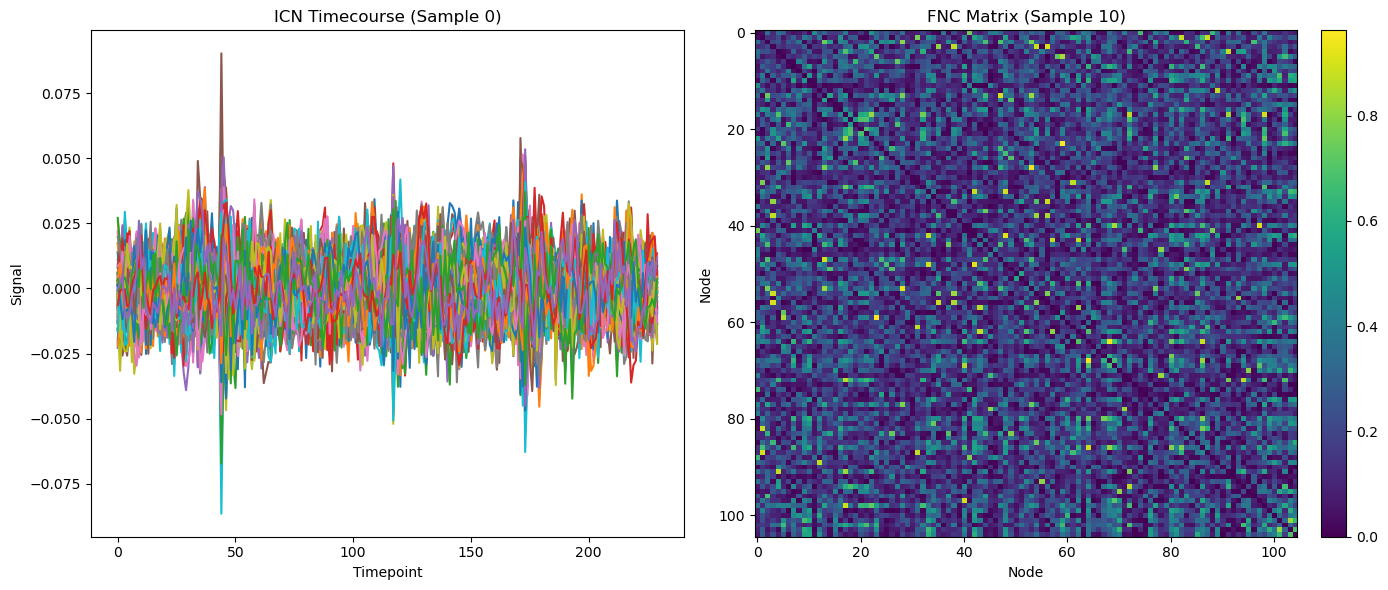

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

i = 10

# Plot ICN timecourse
axs[0].plot(icn_data[i])
axs[0].set_title("ICN Timecourse (Sample 0)")
axs[0].set_xlabel("Timepoint")
axs[0].set_ylabel("Signal")

# Plot FNC matrix
im = axs[1].imshow(fnc_matricies[i], aspect='auto', cmap='viridis')
axs[1].set_title(f"FNC Matrix (Sample {i})")
axs[1].set_xlabel("Node")
axs[1].set_ylabel("Node")
plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [6]:
np.count_nonzero(targets)#/len(train_targets)

183

In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [41]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


graph_data = []
for i in range(len(targets)):
    node_feature = node_features[i]
    edge_index = edge_indicies[i]
    target = targets[i]
    data = Data(x=node_feature, edge_index=edge_index, y=target)
    graph_data.append(data)


mlp_data = []
for fnc, target in zip(fnc_data, targets):
    mlp_data.append((fnc, target))

# train_data, test_data = train_test_split(pyg_data_list, test_size=0.2)
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [9]:
class MLP(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.layer1 = nn.Linear(in_features, 512)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(512, 512)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(512, 64)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout(x)
        x = self.act2(self.layer2(x))
        x = self.dropout(x)
        x = self.act3(self.layer3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

In [19]:
mlp_model = MLP(5460)
print(mlp_model)

MLP(
  (layer1): Linear(in_features=5460, out_features=512, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=512, out_features=512, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=512, out_features=64, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [20]:
mlp_train, mlp_test = train_test_split(mlp_data, test_size=0.2)
mlp_train_loader = DataLoader(mlp_train, batch_size=32, shuffle=True)
mlp_test_loader = DataLoader(mlp_test, batch_size=32, shuffle=False)

In [21]:
def model_train(model, train_loader):
    model.train()
    
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for fnc, target in train_loader:
        y_pred = model(fnc)
        loss = loss_fn(y_pred, target)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()


def test(model, loader):
    model.eval()

    correct = 0
    for fnc, target in loader:  # Iterate in batches over the training/test dataset.
       y_pred = model(fnc)  
       #  pred = torch.where(out > 0.5, 1., 0.)  # Use the class with highest probability.
       correct += int((y_pred.round() == target).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

train_acc_list = []
test_acc_list = []
epochs = 41
for epoch in range(1, epochs):
    model_train(mlp_model, mlp_train_loader)
    train_acc = test(mlp_model, mlp_train_loader)
    test_acc = test(mlp_model, mlp_test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6223, Test Acc: 0.5684
Epoch: 002, Train Acc: 0.6223, Test Acc: 0.5684
Epoch: 003, Train Acc: 0.6223, Test Acc: 0.5684
Epoch: 004, Train Acc: 0.6223, Test Acc: 0.5684
Epoch: 005, Train Acc: 0.6223, Test Acc: 0.5684
Epoch: 006, Train Acc: 0.6223, Test Acc: 0.5684
Epoch: 007, Train Acc: 0.6223, Test Acc: 0.5684
Epoch: 008, Train Acc: 0.6223, Test Acc: 0.5684
Epoch: 009, Train Acc: 0.6223, Test Acc: 0.5684
Epoch: 010, Train Acc: 0.6223, Test Acc: 0.5684
Epoch: 011, Train Acc: 0.6223, Test Acc: 0.5684
Epoch: 012, Train Acc: 0.6277, Test Acc: 0.5684
Epoch: 013, Train Acc: 0.6489, Test Acc: 0.5684
Epoch: 014, Train Acc: 0.6755, Test Acc: 0.5895
Epoch: 015, Train Acc: 0.6835, Test Acc: 0.5895
Epoch: 016, Train Acc: 0.7660, Test Acc: 0.6316
Epoch: 017, Train Acc: 0.7686, Test Acc: 0.6316
Epoch: 018, Train Acc: 0.7872, Test Acc: 0.6526
Epoch: 019, Train Acc: 0.8245, Test Acc: 0.6526
Epoch: 020, Train Acc: 0.8138, Test Acc: 0.6421
Epoch: 021, Train Acc: 0.8245, Test Acc:

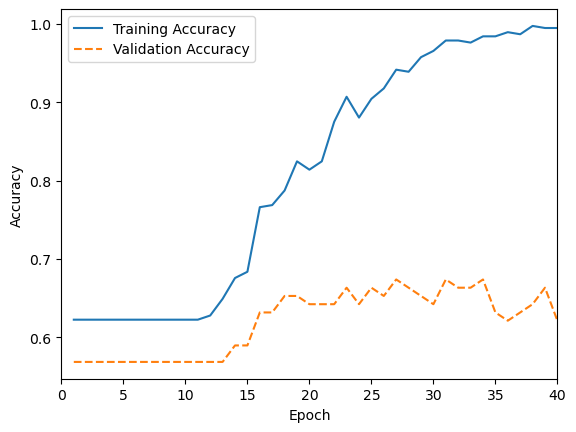

In [25]:
def plot_training(epochs, train_losses, val_losses, benchmark=None):
    """Plot the training and validation losses."""
    plt.plot(range(1,epochs), train_losses, label="Training Accuracy")
    plt.plot(range(1,epochs), val_losses, "--", label="Validation Accuracy")
    # plt.plot([0, epochs - 1], [benchmark, benchmark], ":k", label="Benchmark")
    plt.xlabel("Epoch")
    plt.xlim([0, epochs - 1])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_training(epochs, train_acc_list, test_acc_list)

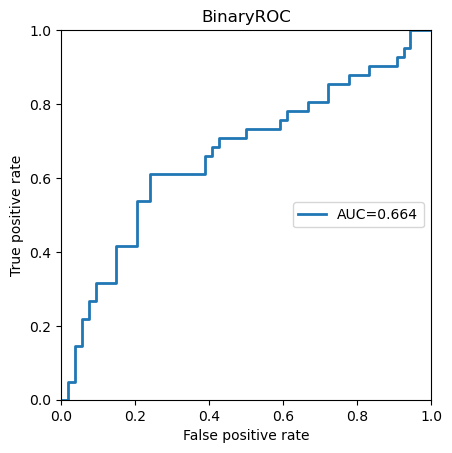

In [51]:
import torchmetrics as tm

def plot_roc(model, loader):
    model.eval()
    """Plot ROC curve."""
    roc = tm.ROC(task="binary")
    for fnc, target in loader:
        roc.update(model(fnc), target.long())

    fig, ax = roc.plot(score=True)
    ax.grid(False)
    ax.axis("square")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(loc="center right")
    plt.show()

plot_roc(mlp_model, mlp_test_loader)

In [27]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


In [28]:
num_node_features = 1
num_classes = 1

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        # x = x.sigmoid()
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


In [45]:
graph_train, graph_test = train_test_split(graph_data, test_size=0.2)
graph_train_loader = DataLoader(graph_train, batch_size=32, shuffle=True)
graph_test_loader = DataLoader(graph_test, batch_size=32, shuffle=True)

In [48]:
graph_model = GCN(hidden_channels=64)

def model_train(model, train_loader):
    model.train()
    
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for data in train_loader:
        y_pred = model(data.x, data.edge_index, data.batch)
        
        loss = loss_fn(y_pred, data.y.unsqueeze(-1))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()


def test(model, loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
       y_pred = model(data.x, data.edge_index, data.batch) 
       #  pred = torch.where(out > 0.5, 1., 0.)  # Use the class with highest probability.
       correct += int((y_pred.round() == data.y.unsqueeze(-1)).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

train_acc_list = []
test_acc_list = []
epochs = 41
for epoch in range(1, epochs):
    model_train(graph_model, graph_train_loader)
    train_acc = test(graph_model, graph_train_loader)
    test_acc = test(graph_model, graph_test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 002, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 003, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 004, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 005, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 006, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 007, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 008, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 009, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 010, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 011, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 012, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 013, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 014, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 015, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 016, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 017, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 018, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 019, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 020, Train Acc: 0.6144, Test Acc: 0.6000
Epoch: 021, Train Acc: 0.6144, Test Acc:

In [295]:
class GraphConvolution(torch.nn.Module):
    """Graph convolution"""

    def forward(self, A, node_attr):
        """Compute the graph convolution."""
        return torch.bmm(A, node_attr)
    

class GCL(dl.DeeplayModule):
    """Graph convolution layer."""

    def __init__(self, in_feats, out_feats):
        """Initialize graph convolution layer."""
        super().__init__()
        self.transform = dl.Layer(torch.nn.Linear, in_feats, out_feats) 
        self.propagate = dl.Layer(GraphConvolution)
        self.update = dl.Layer(torch.nn.ReLU)

    def add_self_loops(self, A):
        """Add diagonal self-loop to adjacency matrix."""
        return A + torch.eye(A.size(0)).to(A.device)

    def normalize(self, A):
        """Normalize adjacency matrix."""
        node_degrees = torch.sum(A, dim=1)
        inv_sqrt_node_degrees = node_degrees.pow(-0.5)
        inv_sqrt_node_degrees[inv_sqrt_node_degrees == float("inf")] = 0
        diag_matrix = torch.diag(inv_sqrt_node_degrees)
        return torch.matmul(torch.matmul(diag_matrix, A), diag_matrix)

    def forward(self, A, node_attr):
        """Transform, propagate and update the node attributes."""
        # A = self.normalize(self.add_self_loops(A))
        A = self.normalize(A)

        # transformed_node_attr = self.transform(node_attr)
        # propagated_node_attr = self.propagate(A, transformed_node_attr)
        # updated_node_attr = self.update(propagated_node_attr)
        updated_node_attr = self.update(node_attr)
        return updated_node_attr
    

class GCN(dl.DeeplayModule):
    """Graph convolutional network."""

    def __init__(self, num_nodes, embed_dim, hidden_feats, out_feats):
        """Initialize graph convolutional network."""
        super().__init__()
        self.node_embed = dl.Layer(torch.nn.Embedding, num_nodes, embed_dim)
        self.blocks = dl.LayerList()
        for f_in, f_out in zip([embed_dim, *hidden_feats[:-1]],
                               hidden_feats):
            self.blocks.append(GCL(in_feats=f_in, out_feats=f_out))
        self.dense_top = dl.Sequential(
            dl.Layer(torch.nn.Linear, hidden_feats[-1], hidden_feats[-1] // 4),
            dl.Layer(torch.nn.ReLU),
            dl.Layer(torch.nn.Linear, hidden_feats[-1] // 4, out_feats), #TODO: ADD Dropout
        )

    
    def forward(self, batch):
        node_attr = batch[1]
        A = batch[0]
        for block in self.blocks:
            node_attr = block(A, node_attr)


    def forward(self, G):
        """Predict graph properties."""
        G["node_attr"] = self.node_embed(G["node_attr"])
        for block in self.blocks:
            G["node_attr"] = block(G["A"], G["node_attr"])

        num_graphs = torch.max(G["graph_ids"]) + 1
        pooled_graph_attr = torch.zeros(
            num_graphs, G["node_attr"].shape[1], device=G["node_attr"].device,
        )
        pooled_graph_attr = pooled_graph_attr.scatter_add(
            0, G["graph_ids"][:, None].expand_as(G["node_attr"]),
            G["node_attr"],
        )
        node_counts = torch.bincount(G["graph_ids"])
        pooled_graph_attr = pooled_graph_attr / node_counts[:, None]

        return self.dense_top(pooled_graph_attr).squeeze()  # LogP
    

class GraphRegressor(dl.Regressor):
    """Regressor model for molecular property prediction."""

    def __init__(self, model, **kwargs):
        """Initialize molecular regressor."""
        super().__init__(model, **kwargs)

    def batch_preprocess(self, G):
        """Preprocess the graph batch for model input."""
        G["node_attr"] = G["x"].squeeze()
        G["A"] = to_dense_adj(G["edge_index"]).squeeze(0)
        G["graph_ids"] = G["batch"]
        return G.to(self.device)

    def forward(self, G):
        """Calculate model output for input graph batch."""
        return self.model(self.batch_preprocess(G))

NameError: name 'dl' is not defined